# MultiMap Generator Script
The purpose of this script is to generate several small, 'thumbnail' size maps that communicate a lot of comparable information in a short space of time. These maps are MatPlotLib objects, and do not require the use of traditional mapping software (QGIS, ArcGIS). They are mainly intended for looking at countries in a 'cross-section' fashion, across more than one dimension at once. 

This script was developed in response to requests to help Puja Guha visualize elements of the Ghana business census. 

***WARNING***: You may need to conda install basemap to your environment before this command will run. In my environment, this required downgrades of common packages (rasterio, libgdal). As such, I recommend you create a fresh conda environment for executing this script. 

My steps were as follows:

- conda create --name 'multimap'
- conda activate multimap
- conda install basemap
- conda install -c conda-forge geopandas
- pip install xlrd ipykernel
- python -m ipykernel install --user --name multimap --display-name "Python (multimap)"

Import some of the usual suspects.

In [1]:
import pandas as pd
import numpy as np
import time, os, sys
import geopandas as gpd
import matplotlib
import xlrd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

Define workspace variables. Basepath must already exist, but output folder can be generated beneath it automatically unless another path is specified.

In [2]:
basepath = r'C:\Users\charl\Documents\GOST\Ghana'
outpath = os.path.join(basepath, 'output')

if not os.path.exists(basepath):
    raise ValueError('basepath does not exist')
    
if not os.path.exists(outpath):
    os.mkdir(outpath)

In this script, we make use of the Ghana business census. This is an excel document. We import it as a pandas DataFrame, taking some care to assign headers across rows 2 and 3. 

In [3]:
df = pd.read_excel(os.path.join(basepath, 'Business Census','Ghana Business Census.xlsx'), 
                   sheet_name = 'SectorOpRev', 
                   header = [2,3])

df = df.set_index(df['_intro_','Region'])
df = df[:10]

This file is organized with several recurring sub-headers for each industry, as we can see below:

In [4]:
df.head(5)

_intro_                 \
                          Sheet         Region   
(_intro_, Region)                                
Western            OpRevWestern        Western   
Central            OpRevCentral        Central   
Greater Accra      OpRevGrAccra  Greater Accra   
Volta                OpRevVolta          Volta   
Eastern            OpRevEastern        Eastern   

                  Agriculture, forestry and fishing                            \
                           Number of Establishments Number of persons engaged   
(_intro_, Region)                                                               
Western                                         708                     17305   
Central                                         153                      3154   
Greater Accra                                   241                      6036   
Volta                                 Data missing!             Data missing!   
Eastern                                         325                      5818   

                                                                     \
                         Revenue Cost of Goods Sold     Input Cost    
(_intro_, Region)                                                     
Western               1525128522           332143861      330156069   
Central                 60741626            15222270       15313074   
Greater Accra          555748814           209196008      195635511   
Volta              Data missing!       Data missing!  Data missing!   
Eastern                108700476            35689089       35488935   

                                                 Industry  \
                   Gross Profit  Number of Establishments   
(_intro_, Region)                                           
Western               1192984658                    10420   
Central                 45519363                     8396   
Greater Accra          346552811                    23976   
Volta              Data missing!            Data missing!   
Eastern                 73011389                    10022   

                                             ...  \
                  Number of persons engaged  ...   
(_intro_, Region)                            ...   
Western                               86062  ...   
Central                               42316  ...   
Greater Accra                        238580  ...   
Volta                         Data missing!  ...   
Eastern                               51954  ...   

                  Sports activities and amusement and recreation activities  \
                                                                    Revenue   
(_intro_, Region)                                                             
Western                                                    149804656          
Central                                                     12845210          
Greater Accra                                              175605525          
Volta                                                  Data missing!          
Eastern                                                      4308131          

                                                                     \
                  Cost of Goods Sold     Input Cost   Gross Profit    
(_intro_, Region)                                                     
Western                      21473747       21461856      128330909   
Central                       1350697        1343220       11494513   
Greater Accra                24908752       24832523      150696769   
Volta                   Data missing!  Data missing!  Data missing!   
Eastern                        193051         192008        4115080   

                  Other service activities                            \
                  Number of Establishments Number of persons engaged   
(_intro_, Region)                                                      
Western                              10912                     51864   
Central  

This organization is refrred to as a multi-index in Pandas. 

For our purposes, we need to create several smaller versions of this dataframe, with consistent information in them. 

We do this by passing a pandas 'IndexSlice' object to the common .loc command. In these slices, we take anything at the first level (':') but only take certain columns in the second level of the index. We then assign these to new variables:

In [5]:
Revenue = df.loc[:, pd.IndexSlice[:, 'Revenue']]
Grossprofit = df.loc[:, pd.IndexSlice[:, 'Gross Profit ']]
COGS = df.loc[:, pd.IndexSlice[:, 'Cost of Goods Sold ']]
NumberEst = df.loc[:, pd.IndexSlice[:, 'Number of Establishments']]
NumberEng = df.loc[:, pd.IndexSlice[:, 'Number of persons engaged']]

for obj in [Revenue,Grossprofit,COGS,NumberEst,NumberEng]:
    obj['ADM1_NAME'] = obj.index

C:\Users\charl\Anaconda3\envs\multimap\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We want to match this information on to a shapefile for visualization of its geospatial aspects. Hence, we import an admin file as a GeoPandas GeoDataFrame:

In [6]:
shp = gpd.read_file(os.path.join(basepath, 'Polygons', 'Adm1.shp'))
shp = shp.set_index('ADM1_NAME')

...and then merge on the attributes on the key field, here called 'ADM1_NAME':

In [7]:
for obj in [Revenue,Grossprofit,COGS,NumberEst,NumberEng]:
    shp = shp.merge(obj, on = 'ADM1_NAME')
shp = shp.set_index('ADM1_NAME')

C:\Users\charl\Anaconda3\envs\multimap\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\charl\Anaconda3\envs\multimap\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


At this point we want to collapse the multi-index to a single level index. Multi-level index objects have a length of 2 (they are a list). Hence, we can identify just these items, and merge them, and then reset shp's columns attribute:

In [8]:
newcols = []
for i in shp.columns:
    if len(i) == 2:
        i = ', '.join(i)
    else:
        pass
    newcols.append(i)
    
shp.columns = newcols

I send this renamed shapefile to file for future reference:

In [9]:
shppath = os.path.join(outpath,'temp.shp')
shp.to_file(shppath,driver = 'ESRI Shapefile')

At this stage I turn my attention to setting up the MatPlotLib environmnet for the generation of the graphics. In turn, I:
- generate 'm', a basemap object. The parameters are the max / min lat / long coordinates, and projection
- add in coastlines
- read in our temp shapefile saved in the last stage
- plot out our skeleton map

C:\Users\charl\Anaconda3\envs\multimap\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\charl\Anaconda3\envs\multimap\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


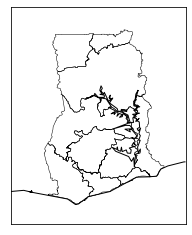

In [10]:
m = Basemap(llcrnrlon=-4.5,llcrnrlat=4.,urcrnrlon=2,urcrnrlat=12.,
            projection='merc',
            resolution ='l')

# draw coastlines
m.drawcoastlines()
m.readshapefile(os.path.join(outpath,'temp'), 'datashp')

plt.show()

At this stage, we select which combinations of sectors and variables we want to plot, and add this to a list called 'cols':

In [11]:
sectors = ['Industry','Mining and quarrying','Manufacturing','Services','Construction']
variables = ['Revenue','Cost of Goods Sold ','Gross Profit ','Number of Establishments']
cols = []

for s in sectors:
    for v in variables:
        cols.append('%s, %s' % (s, v))

Finally, we are in a position to generate our output image. See in line commentary for variables and controls.

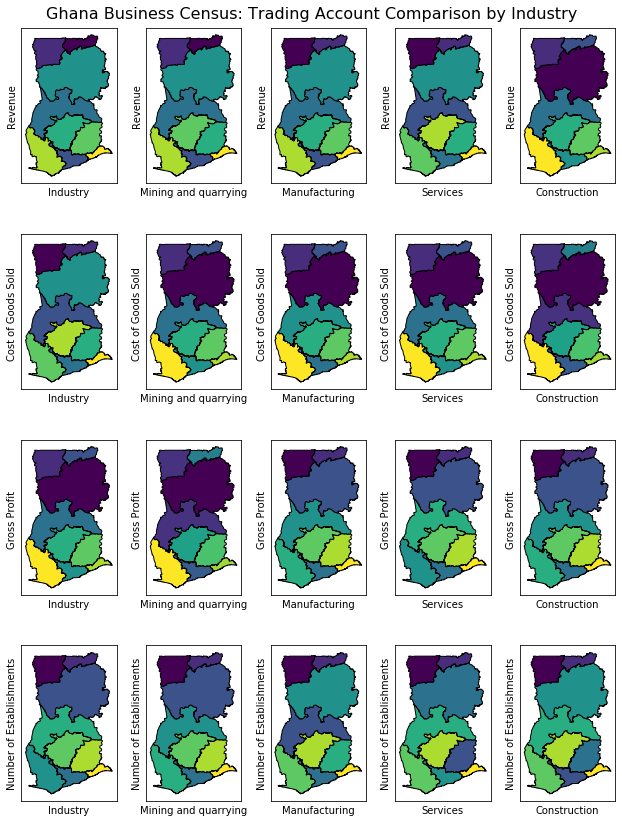

In [18]:
# copy shapefile, drop 'Volta' region as no matching data
data = shp.copy()
data = data.drop('Volta', axis = 0)

# define max, minimum and total latitude and longitude components
max_lon = 1
min_lon = -3.5
max_lat = 11.5
min_lat = 4

# define extents for generating figure size
total_lon = max_lon - min_lon
total_lat = max_lat - min_lat

# define figure sizes
scale = 3
figure_aspect = total_lon / total_lat
figsize = (total_lon*scale, total_lat*scale)

# choose what goes on x and what goes on y
y_labels = variables
x_labels = sectors

# Here I set up a series of subplots (nrows >1, ncols >1). Later, I will plot on these axes in turn
fig, axes = plt.subplots(nrows = len(y_labels),
                         ncols = len(x_labels), 
                         figsize = (len(x_labels)*scale*figure_aspect, len(y_labels)*scale),
                        sharex = True, 
                        sharey = True)


for s in range(0, len(y_labels)):
    
    for v in range(0, len(x_labels)):
        
        # here, I am choosing exactly which axes to populate.
        axis = axes[s,v]        
        
        # and here I am doing the plotting, having chosen which axes to plot on ('axis' variable)
        data.plot(ax=axis, column=cols[v+(s*(len(y_labels)-1))], 
                  cmap = 'viridis', # adjust this to change color scheme, e.g. 'Reds', Blues'
                  legend = False, 
                 edgecolor = 'black') # adjust this for the edge color
        
        axis.set_aspect('equal')
        
        axis.tick_params(
            axis='both',       # changes apply to both axes
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left = False,      # ticks along left edge off
            right = False,     # ticks along right edge off
            labelbottom=False, # removed axis labels along bottom
            labelleft = False) # labels along the left edge are off
        
        axis.set_xlabel(x_labels[v], verticalalignment = 'top')
        
        axis.set_ylabel(y_labels[s])

# change the title for the entire figure
fig.suptitle('Ghana Business Census: Trading Account Comparison by Industry', fontsize=16)

# pad this figure with some whitespace to enable it to be saved down correctly. 
fig.tight_layout(pad=2, w_pad=0.5, h_pad=0.0)